In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import random
from sklearn import metrics
%matplotlib inline

import sys

In [2]:
!pip install imblearn
from imblearn.over_sampling import SMOTE

In [5]:
dat_train = pd.read_feather("../output/dat_train.feather")
dat_test = pd.read_feather("../output/dat_test.feather")


In [6]:
images_train = dat_train.loc[:,dat_train.columns != 'label']
labels_train = dat_train.loc[:,'label'].astype(int)
images_val = dat_test.loc[:,dat_test.columns != 'label']
labels_val = dat_test.loc[:,'label'].astype(int)

In [7]:
images_train = np.array(images_train)
labels_train = np.array(labels_train)
images_val = np.array(images_val)
labels_val = np.array(labels_val)

nepochs = 100
batch_size = 128

In [8]:
sm = SMOTE()
x_res_train, y_res_train = sm.fit_resample(images_train, labels_train)
x_res_val, y_res_val = sm.fit_resample(images_val, labels_val)

In [9]:
def build_model(n_layers,hidden):
    model=keras.Sequential()
    model.add(keras.layers.Flatten())
    for i1 in range(n_layers):
        model.add(keras.layers.Dense(hidden,activation="relu"))
    model.add(keras.layers.Dense(10,activation="softmax"))
    return model


In [13]:
results=[]
layers_array = [1,2,3,4,5]
nodes_array = [16,32,64,128]
for n_layers  in layers_array:
    for hidden in nodes_array:
        model=build_model(n_layers,hidden)
        model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
        model.fit(x = x_res_train, y = y_res_train, batch_size=128, epochs =100, verbose=0, validation_data=(x_res_val,y_res_val))
        Y_pred=np.argmax(model.predict(x_res_val),axis=1)
        acc=np.mean(Y_pred==y_res_val)
        results.append((n_layers,hidden,acc))
        print(f">>>> {n_layers},{hidden}: {acc}")

>>>> 1,16: 0.5
>>>> 1,32: 0.5501022494887525
>>>> 1,64: 0.754601226993865
>>>> 1,128: 0.754601226993865
>>>> 2,16: 0.5
>>>> 2,32: 0.5
>>>> 2,64: 0.6901840490797546
>>>> 2,128: 0.5
>>>> 3,16: 0.5
>>>> 3,32: 0.5
>>>> 3,64: 0.5
>>>> 3,128: 0.6871165644171779
>>>> 4,16: 0.7065439672801636
>>>> 4,32: 0.7443762781186094
>>>> 4,64: 0.591002044989775
>>>> 4,128: 0.6186094069529653
>>>> 5,16: 0.7433537832310838
>>>> 5,32: 0.7433537832310838
>>>> 5,64: 0.6922290388548057
>>>> 5,128: 0.5


In [14]:
data=pd.DataFrame(results,columns=["n_layers","hidden","accuracy"])
data

,n_layers,hidden,accuracy
0,1,16,0.500000
1,1,32,0.550102
2,1,64,0.754601
3,1,128,0.754601
4,2,16,0.500000
5,2,32,0.500000
6,2,64,0.690184
7,2,128,0.500000
8,3,16,0.500000
9,3,32,0.500000


In [15]:
best=data.iloc[data["accuracy"].idxmax()]
best_n_layers=int(best["n_layers"])
best_hidden=int(best["hidden"])
best

n_layers     1.000000
hidden      64.000000
accuracy     0.754601
Name: 2, dtype: float64

In [55]:
tf.random.set_seed(2020)
model = build_model(1,64)
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy']) 
model.fit(x_res_train,y_res_train,
          verbose=0,batch_size=128, epochs =100,
         validation_data=(x_res_val,y_res_val))

In [56]:
Y_pred=np.argmax(model.predict(x_res_val),axis=1)
np.mean(Y_pred==y_res_val)

0.6666666666666666

In [57]:
prob=model.predict_proba(x_res_val)
fpr,tpr,threshold=metrics.roc_curve(y_res_val,prob[:,1])
roc=np.c_[fpr,tpr,threshold]
data=pd.DataFrame(roc,columns=["fpr","tpr","threshold"])

auc=metrics.roc_auc_score(y_res_val,prob[:,1])
print(auc)

0.8436858326955808


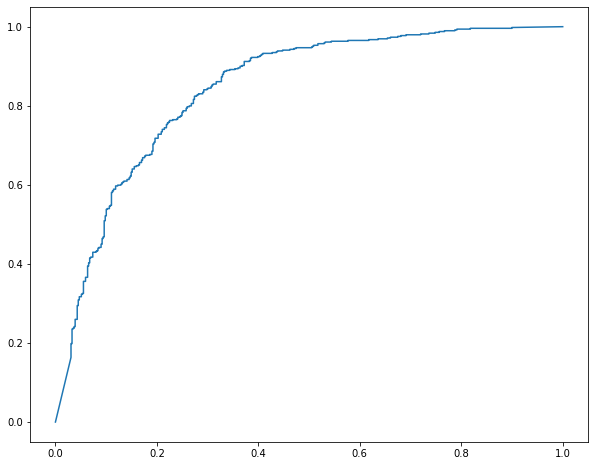

In [58]:
plt.figure(figsize=(10,8))
ax = plt.gca()
plt.plot(fpr,tpr)